In [1]:
#Import all packages needed
import matplotlib as mpl
import matplotlib.pyplot as plt
import os.path, os, sys, copy
import mdtraj as md
from mdtraj.utils.rotation import rotation_matrix_from_quaternion
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline

In [ ]:
plt.rcdefaults()
plt.rcParams.update({ 'axes.linewidth':1, 'axes.labelsize': 12 })
plt.rcParams.update({ 'xtick.labelsize':12, 'ytick.labelsize':12 })

plt.rcParams.update({ 'xtick.major.width': 1.2, 'ytick.major.width': 1.2, 
                    'xtick.major.size': 6, 'ytick.major.size': 6, 'grid.linestyle': ':' })
plt.rcParams.update({ 'figure.figsize': [6.0, 4.0], 'font.size': 12, 'figure.dpi':70 })

In [ ]:
def align_axis(traj,v,axis,cm,indexes,resid1,resid2):
    u = np.array(axis)
    a = np.cross(v,u) 
    a = a / np.linalg.norm(a,axis=1,keepdims=True)
    b = np.arccos( np.dot(v,u) / np.linalg.norm(v,axis=1) )
    # we align D0 to its principal axis
    quaternion = np.insert(np.sin(-b/2).reshape(-1,1)*a,0,np.cos(-b/2),axis=1)
    newxyz = traj.xyz - cm.reshape(-1,1,3)
    newxyz = np.matmul(newxyz,rotation_matrix_from_quaternion(quaternion)) 
    ndx1 = traj.top.select('residue {:d} and name CA'.format(resid1))[0] 
    ndx2 = traj.top.select('residue {:d} and name CA'.format(resid2))[0] 
    # in some frames, D0 is upside-down
    mask = newxyz[:,ndx2,2] > newxyz[:,ndx1,2]
    print(newxyz.shape,mask.sum())
    # we rotate those frames by 180 deg about the x-axis
    newxyz[mask] = np.matmul(newxyz[mask],rotation_matrix_from_quaternion(np.array([0,1,0,0])))
    # let's check that the rotation was successful
    mask = newxyz[:,ndx2,2] > newxyz[:,ndx1,2]
    print(newxyz.shape,mask.sum())
    t = md.Trajectory(newxyz, topology=traj.top, 
                             unitcell_lengths=traj.unitcell_lengths, 
                             unitcell_angles=traj.unitcell_angles)
    return t

def calc_angles(t,N1,N2):
    d1 = t.top.select('index < {:d}'.format(N1))
    d2 = t.top.select('index >= {:d} and index < {:d}'.format(N1,N1+N2))
    td1 = t.atom_slice(d1)
    td2 = t.atom_slice(d2)
    cm2 = md.compute_center_of_mass(td2)
    I1 = md.compute_inertia_tensor(td1)
    w1, v1 = np.linalg.eigh(I1)
    I2 = md.compute_inertia_tensor(td2)
    w2, v2 = np.linalg.eigh(I2)
    v1 = v1[:,:,0].reshape(-1,3)
    v2 = v2[:,:,0].reshape(-1,3)
    angles = np.empty(0)
    for i in range(t.n_frames):
        alpha = np.rad2deg(np.arccos(np.clip(v2[i,2],-1.,1.)))
        if i == 0 and alpha>90:
            v2[i] *= -1
        elif np.linalg.norm(td2.xyz[i,0]-v2[i]-cm2[i]) < np.linalg.norm(td2.xyz[i,0]+v2[i]-cm2[i]):
            v2[i] *= -1
        alpha = np.rad2deg(np.arccos(np.clip(v2[i,2],-1.,1.)))
        angles = np.append(angles, alpha)
    return angles

def align_traj(traj,protein,indexes=[1,97,103,194],resid=[23,29]):
    """The MD trajectory obtained by joining the single windows is aligned in such a way
    that the principal axis of a domain superposes the z-axis.
    indexes: [1,97,103,194] for D0-D1, [18,98,108,204] for D00-D0
    resid: [23,29] for D0-D1, [92,18] for D00-D0
    """
    t = traj.atom_slice(traj.top.select('backbone'))
    # calculate principal axis of the first domain and align it to the z-axis
    d1 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[0],indexes[1]))
    d2 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[2],indexes[3]))
    N1 = len(d1)
    N2 = len(d2)
    td1 = t.atom_slice(d1)
    cm1 = md.compute_center_of_mass(td1)
    I1 = md.compute_inertia_tensor(td1)
    del td1
    v1 = np.linalg.eigh(I1)[1][:,:,0].reshape(-1,3)
    t = align_axis(t,v1,[0,0,1],cm1,indexes,resid[0],resid[1])
    t[0].save_pdb('{}/joined.pdb'.format(protein))
    t.save_xtc('{}/joined.xtc'.format(protein))
    return calc_angles(t,N1,N2)

def cmdist(protein,indexes):
    t = md.load_xtc('{}/joined.xtc'.format(protein),'{}/joined.pdb'.format(protein))
    
    d1 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[0],indexes[1]))
    d2 = t.top.select('((residue > {:d}) and (residue < {:d}))'.format(indexes[1],indexes[2]))
    d3 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[2],indexes[3]))
    
    cm1 = md.compute_center_of_mass(t.atom_slice(d1))
    cm2 = md.compute_center_of_mass(t.atom_slice(d2))
    cm3 = md.compute_center_of_mass(t.atom_slice(d3))
    
    rg1 = md.compute_rg(t.atom_slice(d1),np.array([a.element.mass for a in t.atom_slice(d1).top.atoms]))
    rg2 = md.compute_rg(t.atom_slice(d2),np.array([a.element.mass for a in t.atom_slice(d2).top.atoms]))
    return rg1, rg2, np.linalg.norm(cm3-cm1,axis=1), np.linalg.norm(cm1-cm2,axis=1), np.linalg.norm(cm3-cm2,axis=1)

In [ ]:
!mkdir d00-d0
s = md.load('md_input/d00-d0.pdb')
align_traj(s,'d00-d0',[18,98,108,204],[92,18])
#align_traj(s,'d0-d1',indexes=np.array([3,97,102,195])+557,resid=np.array([29,23])+557) # d0-d1

In [ ]:
t = md.load_netcdf('d00-d0/intimin_nvt.nc','d00-d0/intimin.parm7')
for i in range(1,11):
    ti = md.load_netcdf('d00-d0/intimin_nvt{:d}.nc'.format(i),'d00-d0/intimin.parm7')
    t = md.join([t,ti])
    del ti

In [ ]:
angles = align_traj(t,'d00-d0',[18,98,108,204],[92,18])
#angles = align_traj(t,'d0-d1',indexes=[3,97,102,195],resid=[29,23]) # d0-d1

### Domain-Domain Separation

In [ ]:
rg1, rg2, cm13, cm12, cm23 = cmdist('d00-d0',indexes=[18,98,108,204])
#rg1, rg2, cm13, cm12, cm23 = cmdist('d0-d1',[3,97,102,195]) # d0-d1
np.savetxt('data/d00-d0_cm13.dat',np.c_[np.linspace(0,angles.size*2/1e5,angles.size)[10000:],cm13[10000:]])
np.savetxt('data/d00-d0_cm12.dat',np.c_[np.linspace(0,angles.size*2/1e5,angles.size)[10000:],cm12[10000:]])
np.savetxt('data/d00-d0_cm23.dat',np.c_[np.linspace(0,angles.size*2/1e5,angles.size)[10000:],cm23[10000:]])

### $D_{max}$

In [ ]:
Dmax = []
pairs = t.top.select_pairs('name CA','name CA')
for frame in t:
    d = md.compute_distances(frame,atom_pairs=pairs)
    Dmax.append(d.max())

np.savetxt('data/d00-d0_Dmax.dat',np.c_[np.linspace(0,rg.size*2/1e5,rg.size),Dmax])

### RMSF

In [ ]:
indexes = [0,100,109,203]
#indexes = [3,97,102,195] # d0-d1

d1 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[0],indexes[1]))
d2 = t.top.select('((residue >= {:d}) and (residue <= {:d}))'.format(indexes[2],indexes[3]))

resnums = np.arange(indexes[0]+450,indexes[1]+1+450,1,dtype=int)
#resnums = np.arange(indexes[0]+556,indexes[1]+1+556,1,dtype=int) # d0-d1
td1 = t.atom_slice(d1) 

rmsf = []
for atom in ['N','CA','C','O']:
    tatom = td1.atom_slice(td1.top.select('name '+atom))
    rmsf.append( md.rmsf(tatom[10000:],tatom[0]) )
rmsf_m = np.mean(rmsf,axis=0)
rmsf_s = np.std(rmsf,axis=0)
plt.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(0))
plt.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(0),edgecolor=None)
np.savetxt('data/d00_d00d0_rmsf.dat',np.c_[resnums,rmsf_m,rmsf_s])

resnums = np.arange(indexes[2]+450,indexes[3]+1+450,1,dtype=int)
#resnums = np.arange(indexes[2]+556,indexes[3]+1+556,1,dtype=int) # d0-d1
td2 = t.atom_slice(d2) 

rmsf = []
for atom in ['N','CA','C','O']:
    tatom = td2.atom_slice(td2.top.select('name '+atom))
    rmsf.append( md.rmsf(tatom[10000:],tatom[0]) )
rmsf_m = np.mean(rmsf,axis=0)
rmsf_s = np.std(rmsf,axis=0)
plt.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(0))
plt.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(0),edgecolor=None)
np.savetxt('data/d0_d00d0_rmsf.dat',np.c_[resnums,rmsf_m,rmsf_s])

### Secondary Structure

In [ ]:
assigned = md.compute_dssp(t[10000:],simplified=False)

resids = np.array([res.index for res in t.top.residues])
resids.size

resnums = np.arange(450,resids.size+450,1,dtype=int)
# resnums = np.arange(556,753,1,dtype=int) # d0-d1

In [ ]:
f = .5
for s in ['E','T','H','S']:
    sec = np.sum(assigned==s,axis=0)/assigned.shape[0]
    plt.bar(resnums[sec>f], sec[sec>f].size*[1], width=1, alpha=0.3)
    np.savetxt('data/d00-d0_sec{:s}_{:.1f}.dat'.format(s,f),np.c_[resnums[sec>f], sec[sec>f].size*[2]])
plt.xlim(resnums.min(),resnums.max())

<Figure size 432x288 with 0 Axes>

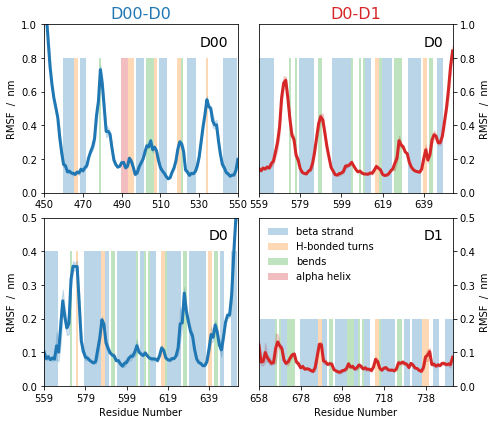

In [2]:
fig = plt.figure()

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(7,6))

resnums,rmsf_m,rmsf_s = np.loadtxt('data/d00_d00d0_rmsf.dat',unpack=True)
ax1.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(0))
ax1.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(0),edgecolor=None)
for s in ['E','T','S','H']:
    x,y = np.loadtxt('data/d00-d0_sec{:s}.dat'.format(s),unpack=True)
    x = x[(x>=resnums.min())&(x<=resnums.max())]
    ax1.bar(x, x.size*[.8], width=1, alpha=0.3)
ymax = rmsf_m.max()
ax1.set_ylim(0,1)
ax1.set_xlim(resnums.min(),resnums.max())
ax1.set_xticks(resnums[::20])

resnums,rmsf_m,rmsf_s = np.loadtxt('data/d0_d0d1_rmsf.dat',unpack=True)
ax2.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(3))
ax2.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(3),edgecolor=None)
for s in ['E','T','S']:
    x,y = np.loadtxt('data/d0-d1_sec{:s}_{:.1f}.dat'.format(s,.5),unpack=True)
    x = x[(x>=resnums.min())&(x<=resnums.max())]
    ax2.bar(x, x.size*[.8], width=1, alpha=0.3)
ax2.set_xlim(resnums.min(),resnums.max())
ax2.set_ylim(0,1)
ax2.set_xticks(resnums[::20])

resnums,rmsf_m,rmsf_s = np.loadtxt('data/d0_d00d0_rmsf.dat',unpack=True)
ax3.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(0))
ax3.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(0),edgecolor=None)
for s in ['E','T','S']:
    x,y = np.loadtxt('data/d00-d0_sec{:s}.dat'.format(s),unpack=True)
    x = x[(x>=resnums.min())&(x<=resnums.max())]
    ax3.bar(x, x.size*[.4], width=1, alpha=0.3)
ax3.set_xlim(resnums.min(),resnums.max())
ax3.set_ylim(0,.5)
ax3.set_xticks(resnums[::20])

resnums,rmsf_m,rmsf_s = np.loadtxt('data/d1_d0d1_rmsf.dat',unpack=True)
ax4.plot(resnums,rmsf_m,lw=3,color=plt.get_cmap('tab10')(3))
ax4.fill_between(resnums,rmsf_m-rmsf_s,rmsf_m+rmsf_s,alpha=.2,color=plt.get_cmap('tab10')(3),edgecolor=None)
for s in ['E','T','S']:
    x,y = np.loadtxt('data/d0-d1_sec{:s}_{:.1f}.dat'.format(s,.5),unpack=True)
    x = x[(x>=resnums.min())&(x<=resnums.max())]
    ax4.bar(x, x.size*[.2], width=1, alpha=0.3)
ax4.set_xlim(resnums.min(),resnums.max())
ax4.set_ylim(0,.5)
ax4.set_xticks(resnums[::20])

blue_patch = mpatches.Patch(color=plt.get_cmap('tab10')(0), label='beta strand',alpha=.3,lw=0)
yellow_patch = mpatches.Patch(color=plt.get_cmap('tab10')(1), label='H-bonded turns',alpha=.3,lw=0)
green_patch = mpatches.Patch(color=plt.get_cmap('tab10')(2), label='bends',alpha=.3,lw=0)
red_patch = mpatches.Patch(color=plt.get_cmap('tab10')(3), label='alpha helix',alpha=.3,lw=0)
plt.legend(handles=[blue_patch,yellow_patch,green_patch,red_patch],loc='upper left',frameon=False)

ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position('right')

ax4.yaxis.set_label_position("right")
ax4.yaxis.set_ticks_position('right')

ax1.annotate('D00',xy=(0.95,0.87),xycoords='axes fraction',fontsize=14,horizontalalignment='right')
ax2.annotate('D0',xy=(0.95,0.87),xycoords='axes fraction',fontsize=14,horizontalalignment='right')
ax3.annotate('D0',xy=(0.95,0.87),xycoords='axes fraction',fontsize=14,horizontalalignment='right')
ax4.annotate('D1',xy=(0.95,0.87),xycoords='axes fraction',fontsize=14,horizontalalignment='right')

ax1.set_title('D00-D0',fontdict={'fontsize':16,'color':plt.get_cmap('tab10')(0)})
ax2.set_title('D0-D1',fontdict={'fontsize':16,'color':plt.get_cmap('tab10')(3)})
ax1.set_ylabel('RMSF  /  nm')
ax2.set_ylabel('RMSF  /  nm')
ax3.set_ylabel('RMSF  /  nm')
ax4.set_ylabel('RMSF  /  nm')
ax3.set_xlabel('Residue Number')
ax4.set_xlabel('Residue Number')
plt.tight_layout(h_pad=.4,w_pad=.2)